# DoH detection using Network Traffic Classification based on Single Flow Time Series Analysis 

Problem: binary detection of DoH

Raw data from: CESNET-DoH-Real-world [1]

-----------------------------------------------------------------------
[1] Kamil Jeřábek et al. Collection of datasets with DNS over HTTPS traffic. Data in Brief, 42:108310, 2022

In [1]:
import pandas as pd
import numpy as np
import json
import collections

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

In [2]:
df = pd.read_csv("../cnsm_final_datasets/doh_real_world.csv")

In [3]:
df

,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,...,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL
0,0,104.16.248.249.,199.33.242.28,2,0,94,0,1.627832e+09,1.627832e+09,443,...,309211.765871,0.693060,0.447547,NaN,NaN,6623.970310,49333.341521,-0.000199,0.000222,True
1,1,199.33.242.28.,104.16.248.249,1,0,104,0,1.627832e+09,1.627832e+09,10405,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,True
2,2,2606:4700::6810:f8f9.,7295:7731:224:92e:1744:c234:e720:f59f,6,0,305,0,1.627832e+09,1.627832e+09,443,...,-7423.432092,0.824975,0.535767,NaN,NaN,-5341.687979,123.537245,0.179595,0.195987,True
3,3,7295:7731:224:92e:1744:c234:e720:f59f.,2606:4700::6810:f8f9,3,0,333,0,1.627832e+09,1.627832e+09,35256,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,True
4,4,2606:4700::6810:f8f9.,7295:7731:224:92e:1744:c234:e720:f59f,2,0,101,0,1.627833e+09,1.627833e+09,443,...,154719.633104,0.459229,-0.500665,NaN,NaN,10866.305528,11923.113921,-0.000199,0.000848,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5591897,5591897,173.234.109.172.,10.76.167.128,184078,0,267951804,0,1.634845e+09,1.634845e+09,54986,...,13755.368573,0.017792,0.388901,0.302204,-0.310487,7.182623,0.003384,-0.163105,1.000000,False
5591898,5591898,248.33.143.215.,173.234.109.172,11,0,5187,0,1.634845e+09,1.634845e+09,443,...,2909.788741,0.645380,0.532619,0.288483,0.090480,1.211719,0.156491,0.993135,0.205910,False
5591899,5591899,173.234.109.172.,248.33.143.215,11,0,7112,0,1.634845e+09,1.634845e+09,55227,...,4475.304837,0.842457,0.546222,0.290157,0.127113,1.403395,0.162800,0.993135,0.175488,False
5591900,5591900,102.214.20.44.,206.72.85.24,1,0,0,0,1.634845e+09,1.634845e+09,443,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,False


In [4]:
default_faetures = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
]

statistics_features = [
    "MEAN",
    "MEDIAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "Q1",
    "Q3",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "MODE",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "PERCENT_BELOW_MEAN",
    "PERCENT_ABOVE_MEAN",
    "PEARSON_SK1_SKEWNESS",
    "PEARSON_SK2_SKEWNESS",
    "FISHER_MI_3_SKEWNESS",
    "FISHER_PEARSON_g1_SKEWNESS",
    "FISHER_PEARSON_G1_SKEWNESS",
    "GALTON_SKEWNESS",
    "KURTOSIS",
    "ENTROPY",
    "SCALED_ENTROPY",
]
distribution_features = [
    "HURST_EXPONENT",
    "BENFORD_LAW_PRESENTED",
    "P_BENFORD",
    "NORMAL_DISTRIBUTION",
    "CNT_DISTRIBUTION",
    "TIME_DISTRIBUTION",
    "AREA_VALUES_DISTRIBUTION",
]
time_features = [
    "MEAN_SCALED_TIME",
    "MEDIAN_SCALED_TIME",
    "Q1_SCALED_TIME",
    "Q3_SCALED_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MEDIAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "MEAN_SCALED_DIFFTIMES",
    ]
behavior_features = [
    "SIG_SPACES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
    "TRANSIENTS",
    "CNT_ZEROS",
    "CNT_NZ_DISTRIBUTION",
    "BIGGEST_CNT_1_SEC",
    "PERIODICITY",
    "VAL",
    "TIME",
]
frequency_features = [
    "MIN_POWER",
    "MAX_POWER",
    "MIN_POWER_FREQ",
    "MAX_POWER_FREQ",
    "POWER_MEAN",
    "POWER_STD",
    "POWER_MODE",
    "SPECTRAL_ENERGY",
    "SPECTRAL_ENTROPY",
    "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS",
    "SPECTRAL_ROLLOFF",
    "SPECTRAL_CENTROID",
    "SPECTRAL_SPREAD",
    "SPECTRAL_SLOPE",
    "SPECTRAL_CREST",
    "SPECTRAL_FLUX",
    "SPECTRAL_BANDWIDTH",
    "PERIODICITY_SCDF",
]

features = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
    "MEAN",
    "MEDIAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "Q1",
    "Q3",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "MODE",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "PERCENT_BELOW_MEAN",
    "PERCENT_ABOVE_MEAN",
    "PEARSON_SK1_SKEWNESS",
    "PEARSON_SK2_SKEWNESS",
    "FISHER_MI_3_SKEWNESS",
    "FISHER_PEARSON_g1_SKEWNESS",
    "FISHER_PEARSON_G1_SKEWNESS",
    "GALTON_SKEWNESS",
    "KURTOSIS",
    "ENTROPY",
    "SCALED_ENTROPY",
    "HURST_EXPONENT",
    "BENFORD_LAW_PRESENTED",
    "P_BENFORD",
    "NORMAL_DISTRIBUTION",
    "CNT_DISTRIBUTION",
    "TIME_DISTRIBUTION",
    "AREA_VALUES_DISTRIBUTION",
    "MEAN_SCALED_TIME",
    "MEDIAN_SCALED_TIME",
    "Q1_SCALED_TIME",
    "Q3_SCALED_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MEDIAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "MEAN_SCALED_DIFFTIMES",
    "SIG_SPACES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
    "TRANSIENTS",
    "CNT_ZEROS",
    "CNT_NZ_DISTRIBUTION",
    "BIGGEST_CNT_1_SEC",
    "PERIODICITY",
    "VAL",
    "TIME",
    "MIN_POWER",
    "MAX_POWER",
    "MIN_POWER_FREQ",
    "MAX_POWER_FREQ",
    "POWER_MEAN",
    "POWER_STD",
    "POWER_MODE",
    "SPECTRAL_ENERGY",
    "SPECTRAL_ENTROPY",
    "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS",
    "SPECTRAL_ROLLOFF",
    "SPECTRAL_CENTROID",
    "SPECTRAL_SPREAD",
    "SPECTRAL_SLOPE",
    "SPECTRAL_CREST",
    "SPECTRAL_FLUX",
    "SPECTRAL_BANDWIDTH",
    "PERIODICITY_SCDF",
]

In [5]:
import sklearn
pd.set_option('display.max_columns', None)

df['LABEL'] = df.LABEL.astype('category')
df["LABEL_code"] = df["LABEL"].cat.codes

bool_features = ["TRANSIENTS", "BENFORD_LAW_PRESENTED", "SIG_SPACES", "PERIODICITY","PERIODICITY_SCDF"]


for F in features:
    if F in bool_features:
        continue
    if F in distribution_features:
        df.loc[df[F].isnull(), F] = 0.5
    elif F in ["DIRECTIONS","NORMAL_DISTRIBUTION"]: 
        df.loc[df[F].isnull(), F] = 0.5
    else:
        df.loc[df[F].isnull(), F] = 0


for F in bool_features:
    df.loc[df[F].isnull(), F] = False
    df[F] = df[F].astype('bool')

In [6]:
df

,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,SRC_PORT,MEAN,MEDIAN,STDEV,VAR,BURSTINESS,Q1,Q3,MIN,MAX,MIN_MINUS_MAX,MODE,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,PERCENT_BELOW_MEAN,PERCENT_ABOVE_MEAN,PEARSON_SK1_SKEWNESS,PEARSON_SK2_SKEWNESS,FISHER_MI_3_SKEWNESS,FISHER_PEARSON_g1_SKEWNESS,FISHER_PEARSON_G1_SKEWNESS,GALTON_SKEWNESS,KURTOSIS,ENTROPY,SCALED_ENTROPY,HURST_EXPONENT,BENFORD_LAW_PRESENTED,P_BENFORD,NORMAL_DISTRIBUTION,CNT_DISTRIBUTION,TIME_DISTRIBUTION,AREA_VALUES_DISTRIBUTION,MEAN_SCALED_TIME,MEDIAN_SCALED_TIME,Q1_SCALED_TIME,Q3_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MEDIAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,MEAN_SCALED_DIFFTIMES,SIG_SPACES,SWITCHING_METRIC,TRANSIENTS,CNT_ZEROS,CNT_NZ_DISTRIBUTION,BIGGEST_CNT_1_SEC,DIRECTIONS,PERIODICITY,VAL,TIME,MIN_POWER,MAX_POWER,MIN_POWER_FREQ,MAX_POWER_FREQ,POWER_MEAN,POWER_STD,POWER_MODE,SPECTRAL_ENERGY,SPECTRAL_ENTROPY,SPECTRAL_KURTOSIS,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL,LABEL_code
0,0,104.16.248.249.,199.33.242.28,2,0,94,0,1.627832e+09,1.627832e+09,443,10405,107,107.0,66.468037,4418,-0.233657,83.50,130.50,60,154,94,60,62.119661,47,43.925234,116.867446,0.500000,0.500000,0.707107,3.219593,-2.414694,0.000000e+00,0.000000e+00,0.000000,0.250000,1.000000,1.000000,0.563329,False,0.477121,0.0,0.0,0.500000,0.660714,0.007508,0.015015,0.000000,0.015015,0.015015,0.015015,0.015015,0.015015,0.015015,1.000000,False,2.000000,False,0.0,0.0,214,1.0,False,0,0.000000,-3.969430e+03,20699.041229,0.693259,0.693060,3.124869,305.566447,1.00000,15624.346320,0.000000,2.108215e+07,309211.765871,0.693060,0.447547,0.000000,0.000000,6623.970310,49333.341521,-0.000199,True,True,1
1,1,199.33.242.28.,104.16.248.249,1,0,104,0,1.627832e+09,1.627832e+09,10405,443,164,164.0,164.000000,0,0.000000,164.00,164.00,164,164,0,164,100.000000,0,0.000000,164.000000,0.000000,0.000000,0.000000,2.000000,-3.000000,0.000000e+00,-0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,False,0.301030,0.0,0.0,0.500000,0.875000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,0.000000,False,0.0,0.0,164,1.0,False,0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000,0.006667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,True,1
2,2,2606:4700::6810:f8f9.,7295:7731:224:92e:1744:c234:e720:f59f,6,0,305,0,1.627832e+09,1.627832e+09,443,35256,110,109.5,55.731499,3107,-0.327448,60.00,159.75,60,166,106,60,50.664999,50,45.454545,121.954226,0.500000,0.500000,0.897159,3.956470,-0.768241,4.814116e-06,6.592000e-06,-0.002506,0.701398,1.792481,0.693426,0.778394,False,0.689545,0.0,1.0,0.566047,0.625000,38.605917,47.619124,0.007496,68.194590,68.202678,13.640536,0.008088,0.007496,47.604121,0.286541,False,2.000000,False,0.0,1.0,439,1.0,False,0,0.000000,-8.359063e+00,8.591412,0.645380,0.824975,-0.001608,0.199051,0.00092,-8.041852,0.000000,6.787959e+06,-7423.432092,0.824975,0.535767,0.000000,0.000000,-5341.687979,123.537245,0.179595,True,True,1
3,3,7295:7731:224:92e:1744:c234:e720:f59f.,2606:4700::6810:f8f9,3,0,333,0,1.627832e+09,1.627832e+09,35256,443,171,171.0,0.000000,0,-1.000000,171.00,171.00,171,171,0,171,0.000000,0,0.000000,171.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,False,0.301030,0.0,1.0,0.566056,0.875000,38.601811,47.611156,0.000000,68.194277,68.194277,34.097139,34.097139,20.583121,47.611156,0.716159,False,0.000000,False,0.0,1.0,342,1.0,True,171,47.611156,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000,0.006667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,True,1
4,4,2606:4700::6810:f8f9.,7295:7731:224:92e:1744:c234:e720:f59f,2,0,101,0,1.627833e+09,1.627833e+09,443,3525

In [7]:
print(f"hod: {len(df[df['LABEL'] == True])}\tclear: {len(df[df['LABEL'] == False])}")

hod: 5139605	clear: 452297


In [8]:
df = df[["LABEL_code"] + features].copy()

In [9]:
df.replace([np.inf], 0, inplace=True)
df.replace([-np.inf], 0, inplace=True)

In [10]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)

In [11]:
print(f"doh: {len(df[df['LABEL_code'] == 1])}\tclear: {len(df[df['LABEL_code'] == 0])}")

doh: 5139605	clear: 452297


In [12]:
df_validation = df.sample(n=500000)
df_features =  df[~df.isin(df_validation)].dropna()

In [13]:
len(df_features)

5091902

In [14]:
len(df_features)*0.7

3564331.4

In [15]:
len(df_features) - 3564331

1527571

In [16]:
df_features

,LABEL_code,PACKETS,PACKETS_REV,BYTES,BYTES_REV,MEAN,MEDIAN,STDEV,VAR,BURSTINESS,Q1,Q3,MIN,MAX,MIN_MINUS_MAX,MODE,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,PERCENT_BELOW_MEAN,PERCENT_ABOVE_MEAN,PEARSON_SK1_SKEWNESS,PEARSON_SK2_SKEWNESS,FISHER_MI_3_SKEWNESS,FISHER_PEARSON_g1_SKEWNESS,FISHER_PEARSON_G1_SKEWNESS,GALTON_SKEWNESS,KURTOSIS,ENTROPY,SCALED_ENTROPY,HURST_EXPONENT,BENFORD_LAW_PRESENTED,P_BENFORD,NORMAL_DISTRIBUTION,CNT_DISTRIBUTION,TIME_DISTRIBUTION,AREA_VALUES_DISTRIBUTION,MEAN_SCALED_TIME,MEDIAN_SCALED_TIME,Q1_SCALED_TIME,Q3_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MEDIAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,MEAN_SCALED_DIFFTIMES,SIG_SPACES,SWITCHING_METRIC,DIRECTIONS,TRANSIENTS,CNT_ZEROS,CNT_NZ_DISTRIBUTION,BIGGEST_CNT_1_SEC,PERIODICITY,VAL,TIME,MIN_POWER,MAX_POWER,MIN_POWER_FREQ,MAX_POWER_FREQ,POWER_MEAN,POWER_STD,POWER_MODE,SPECTRAL_ENERGY,SPECTRAL_ENTROPY,SPECTRAL_KURTOSIS,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF
0,1.0,2.0,0.0,94.0,0.0,107.0,107.0,66.468037,4418.0,-0.233657,83.5,130.50,60.0,154.0,94.0,60.0,62.119661,47.0,43.925234,116.867446,0.500000,0.500000,0.707107,3.219593,-2.414694,0.000000e+00,0.000000e+00,0.000000,0.250000,1.000000,1.000000,0.563329,0.0,0.477121,0.0,0.0,0.500000,0.660714,0.007508,0.015015,0.000000,0.015015,0.015015,0.015015,0.015015,0.015015,0.015015,1.000000,0.0,2.000000,1.0,0.0,0.0,0.0,214.0,0.0,0.0,0.000000,-3.969430e+03,20699.041229,0.693259,0.693060,3.124869,305.566447,1.00000,15624.346320,0.000000,2.108215e+07,309211.765871,0.693060,0.447547,0.000000,0.000000,6623.970310,49333.341521,-0.000199,1.0
1,1.0,1.0,0.0,104.0,0.0,164.0,164.0,164.000000,0.0,0.000000,164.0,164.00,164.0,164.0,0.0,164.0,100.000000,0.0,0.000000,164.000000,0.000000,0.000000,0.000000,2.000000,-3.000000,0.000000e+00,-0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.301030,0.0,0.0,0.500000,0.875000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,164.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000,0.006667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,1.0,6.0,0.0,305.0,0.0,110.0,109.5,55.731499,3107.0,-0.327448,60.0,159.75,60.0,166.0,106.0,60.0,50.664999,50.0,45.454545,121.954226,0.500000,0.500000,0.897159,3.956470,-0.768241,4.814116e-06,6.592000e-06,-0.002506,0.701398,1.792481,0.693426,0.778394,0.0,0.689545,0.0,1.0,0.566047,0.625000,38.605917,47.619124,0.007496,68.194590,68.202678,13.640536,0.008088,0.007496,47.604121,0.286541,0.0,2.000000,1.0,0.0,0.0,1.0,439.0,0.0,0.0,0.000000,-8.359063e+00,8.591412,0.645380,0.824975,-0.001608,0.199051,0.00092,-8.041852,0.000000,6.787959e+06,-7423.432092,0.824975,0.535767,0.000000,0.000000,-5341.687979,123.537245,0.179595,1.0
3,1.0,3.0,0.0,333.0,0.0,171.0,171.0,0.000000,0.0,-1.000000,171.0,171.00,171.0,171.0,0.0,171.0,0.000000,0.0,0.000000,171.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.301030,0.0,1.0,0.566056,0.875000,38.601811,47.611156,0.000000,68.194277,68.194277,34.097139,34.097139,20.583121,47.611156,0.716159,0.0,0.000000,1.0,0.0,0.0,1.0,342.0,1.0,171.0,47.611156,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000,0.006667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,1.0,1.0,0.0,110.0,0.0,170.0,170.0,170.000000,0.0,0.000000,170.0,170.00,170.0,170.0,0.0,170.0,100.000000,0.0,0.000000,170.000000,0.000000,0.000000,0.000000,2.000000,-3.000000,0.000000e+00,-0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.301030,0.0,0.0,0.500000,0.875000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,170.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000

In [17]:
def get_confusion_matrix(y_test, y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_test, y_pred)
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return matrix, percentage_matrix

def plot_confusion_matrix(matrix, percentage_matrix, model=""):
    # Build the plot
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[0])
    sns.heatmap(percentage_matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[1])
    # Add labels to the plot
    plt.tick_params(axis='both', which='minor', labelsize=5)
    # tick_marks = np.arange(len(classifications_array)) + 0.5
    # plt.xticks(tick_marks, classifications_array, rotation=85)
    # plt.yticks(tick_marks, classifications_array, rotation=0)
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_title(f'Absolute Confusion Matrix for {model}')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_title(f'Relative Confusion Matrix for {model}')
    # pyplot.savefig("ddos_timeseries_plugin_classification.eps", format="eps")
    plt.show()

In [18]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error

def tunne_together_XGBoost_classification(df_tunne, _features, verbose=True):
    X=df_tunne[_features]  # Features
    y=df_tunne['LABEL_code']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify=y)
    
    def objective(space):
        clf = XGBClassifier(
                        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']), 
                        # subsample=int(space['subsample']),
                        # eta=space['eta'],
                            )

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        # accuracy = mean_absolute_error(y_test, pred)
        # accuracy = accuracy_score(y_test, pred)
        accuracy = f1_score(y_test, pred)
        if verbose is True:
            print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }
    
    space={'max_depth': hp.quniform("max_depth", 5, 30, 2),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 80, 400, 20),
        # 'subsample': hp.quniform('subsample', 3, 20, 1),
        # 'eta': hp.quniform('eta', 0.005, 0.3, 0.005),
        'seed': 0
    }
    
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
        
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)
    return best_hyperparams

In [19]:
df_to_tunne = df_features.sample(100000)
best_hyperparams = tunne_together_XGBoost_classification(df_to_tunne, features, verbose=False)

100%|██████████| 100/100 [05:07<00:00,  3.08s/trial, best loss: -0.9784651527016444]
The best hyperparameters are :  

{'colsample_bytree': 0.31570607366065695, 'gamma': 2.32721852714952, 'max_depth': 30.0, 'min_child_weight': 15.0, 'n_estimators': 380.0, 'reg_alpha': 1.0, 'reg_lambda': 0.6412899360139827}


In [20]:

def while_XGBoost_classification_tunned(best_hyperparams, cycles=100):
    X=df_features[features]  # Features
    y=df_features['LABEL_code']  # Labels
    best_results = (0,"",None,None, None)
    i = 0
    print(f"\r{i}", end="")
    for i in range(cycles):
        print(f"\r{i}", end="", flush=True)
        tmp_f1 = 0
        tmp_str = ""
        #Split on train and test
        X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
        for F, N in zip(
                [ features], # statistics_features, time_features, distribution_features, frequency_features, behavior_features, 
                [ "All"], # "Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based", 
        ):
                X_train = X_train_a[F]
                X_test = X_test_a[F] 
                model = XGBClassifier(
                        n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                        reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                        colsample_bytree=int(best_hyperparams['colsample_bytree']),
                        # subsample=int(best_hyperparams['subsample']),
                        # eta=best_hyperparams['eta'],
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
                precision = precision_score(y_test, y_pred)  * 100
                recall = recall_score(y_test, y_pred)  * 100
                F1 = f1_score(y_test, y_pred)  * 100
                if N == "All":
                    tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\hline"
                    tmp_str += "\n"
                    tmp_f1 = F1
                elif N in ["Statistical-based", "Distribution-based", "Behavior-based"]:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
                else:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & \\rowcolor{LigthGray} " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
        if best_results[0] < tmp_f1:
            matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
            best_results = (tmp_f1, tmp_str, matrix, percentage_matrix, model)
    print("")
    print("")
    print("")
    print(best_results[0])
    print(best_results[1])
    plot_confusion_matrix(best_results[2], best_results[3], model="XGBoost")
    return best_results[4]

9


98.5121231090135
\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}97.23 & 97.35 & 99.70 & 98.51 \\
\hline



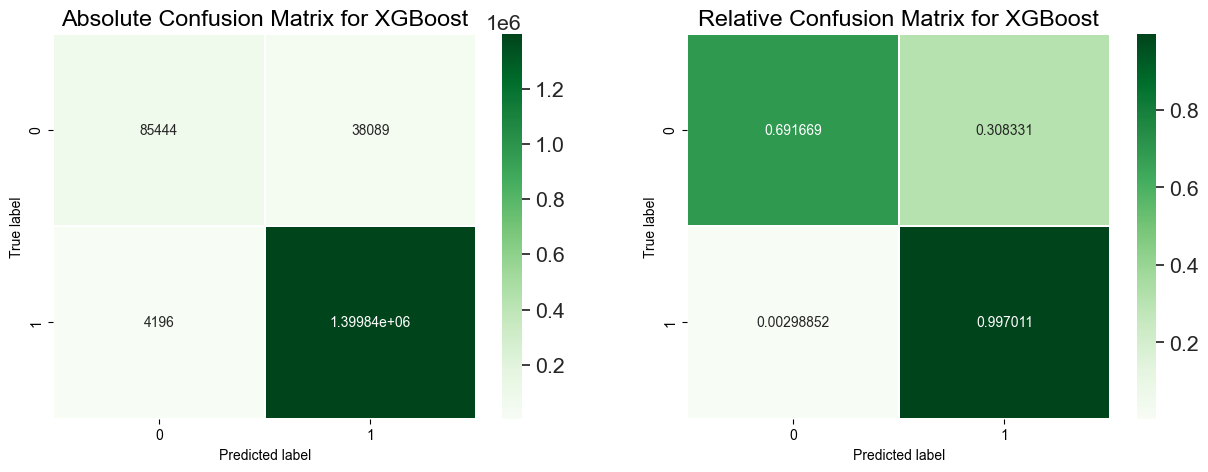

In [21]:
best_model = while_XGBoost_classification_tunned(best_hyperparams, cycles=10)

# Validation

\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}97.23 & 97.35 & 99.70 & 98.51 \\
\hline



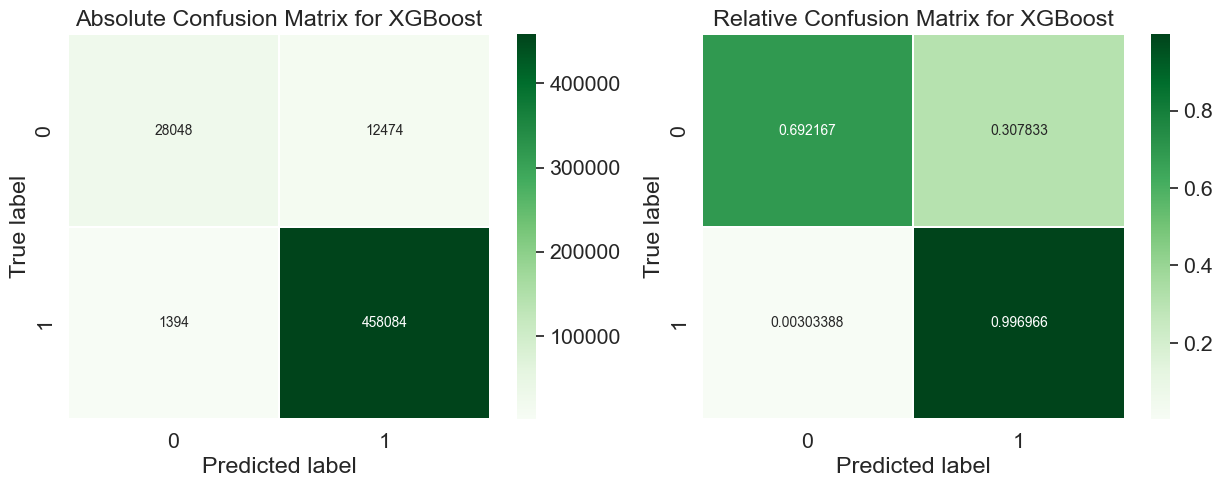

In [22]:
X_validation=df_validation[features]  # Features
y_validation=df_validation['LABEL_code']  # Labels
    

y_pred = best_model.predict(X_validation)
accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
precision = precision_score(y_validation, y_pred)  * 100
recall = recall_score(y_validation, y_pred)  * 100
F1 = f1_score(y_validation, y_pred)  * 100
                
tmp_str = ""
tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
tmp_str += "\n"
tmp_str += "\hline"
tmp_str += "\n"
print(tmp_str)

matrix, percentage_matrix = get_confusion_matrix(y_validation, y_pred)
plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")

In [23]:
import csv

problem = "DoH_RealWorld"
with open("feature_reduction_results.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow([problem, "-", accuracy, precision, recall, F1, 0, 0, 0])

# Feature importance

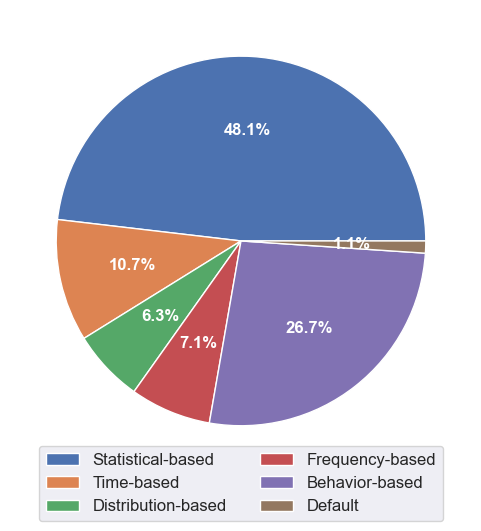

In [24]:
feat_importances = pd.Series(best_model.feature_importances_, index = X_validation.columns).sort_values(ascending = True)

f_sf = feat_importances[statistics_features].sum()
f_tf = feat_importances[time_features].sum()
f_df = feat_importances[distribution_features].sum()
f_ff = feat_importances[frequency_features].sum()
f_bf = feat_importances[behavior_features].sum()
f_def = feat_importances[default_faetures].sum() 

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
data = [f_sf, f_tf, f_df, f_ff, f_bf, f_def]
ingredients = ["Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based", "Default"]
def func(pct, allvals):
    return "{:.1f}%".format(pct)
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, ingredients,
          loc="center",
          bbox_to_anchor=(0.5, 0, 0, -0.05),
          prop={'size': 12},
          ncol=2)
plt.setp(autotexts, size=12, weight="bold")
plt.show()

In [25]:
data

[0.48148483, 0.10690947, 0.06332335, 0.07085289, 0.26687887, 0.010550501]

In [26]:
feat_importances

PERIODICITY_SCDF     0.000000
PACKETS_REV          0.000000
BYTES_REV            0.000000
DIRECTIONS           0.000000
SPECTRAL_SKEWNESS    0.001351
                       ...   
MAX                  0.054525
MIN_MINUS_MAX        0.073487
VAL                  0.088106
MEDIAN               0.095272
TRANSIENTS           0.102888
Length: 76, dtype: float32

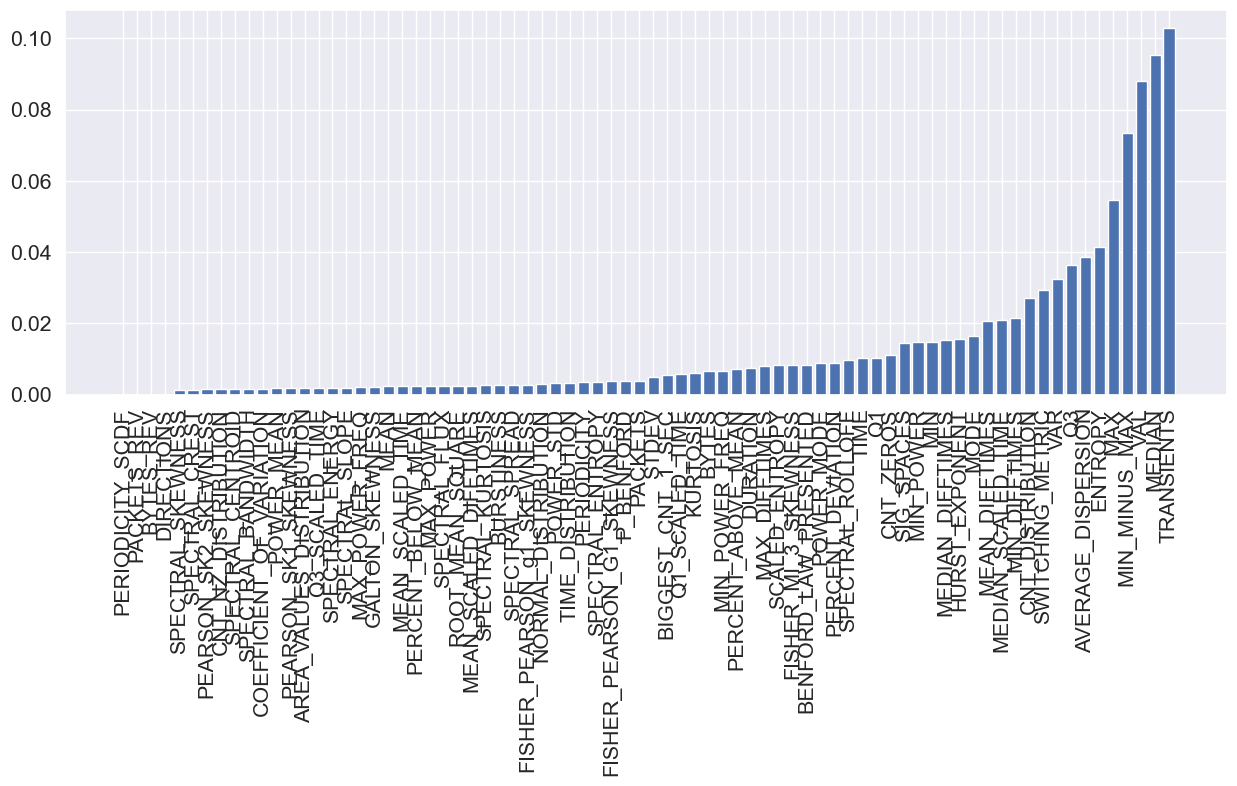

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(feat_importances.keys(), feat_importances.values)
plt.xticks(rotation = 90)
plt.show()

In [28]:
feat_importances.to_dict()

{'PERIODICITY_SCDF': 0.0,
 'PACKETS_REV': 0.0,
 'BYTES_REV': 0.0,
 'DIRECTIONS': 0.0,
 'SPECTRAL_SKEWNESS': 0.001350953010842204,
 'SPECTRAL_CREST': 0.0013591026654466987,
 'PEARSON_SK2_SKEWNESS': 0.00153013551607728,
 'CNT_NZ_DISTRIBUTION': 0.0015399307012557983,
 'SPECTRAL_CENTROID': 0.001559984521009028,
 'SPECTRAL_BANDWIDTH': 0.0015890293288975954,
 'COEFFICIENT_OF_VARIATION': 0.0016800654120743275,
 'POWER_MEAN': 0.0017388842534273863,
 'PEARSON_SK1_SKEWNESS': 0.001847241073846817,
 'AREA_VALUES_DISTRIBUTION': 0.0018546938663348556,
 'Q3_SCALED_TIME': 0.001900386530905962,
 'SPECTRAL_ENERGY': 0.0019319300772622228,
 'SPECTRAL_SLOPE': 0.002004895592108369,
 'MAX_POWER_FREQ': 0.002017468912526965,
 'GALTON_SKEWNESS': 0.0021916101686656475,
 'MEAN': 0.0023054955527186394,
 'MEAN_SCALED_TIME': 0.0023150050546973944,
 'PERCENT_BELOW_MEAN': 0.0024283984676003456,
 'MAX_POWER': 0.0024758498184382915,
 'SPECTRAL_FLUX': 0.002481088973581791,
 'ROOT_MEAN_SQUARE': 0.0025212992914021015,
 'ME

# Feature selection

In [29]:
def perform_val(selected_features, best_hyperparams=None, cycles=10):
    if best_hyperparams is None:
        best_hyperparams = tunne_together_XGBoost_classification(df_features.sample(100000), selected_features, verbose=False)
    
    X=df_features[selected_features]  # Features
    y=df_features['LABEL_code']  # Labels

    best = 0
    best_model = None
    for i in range(0, cycles):    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test   
        model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
        )
        model.fit(X_train, y_train)                
        y_pred = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
        precision = precision_score(y_test, y_pred)  * 100
        recall = recall_score(y_test, y_pred)  * 100
        F1 = f1_score(y_test, y_pred)  * 100
        if F1 > best:   
            best = F1
            best_model = model
            
    
    X_validation=df_validation[selected_features]  # Features
    y_validation=df_validation['LABEL_code']  # Labels

    y_pred = best_model.predict(X_validation)
    accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
    precision = precision_score(y_validation, y_pred)  * 100
    recall = recall_score(y_validation, y_pred)  * 100
    F1 = f1_score(y_validation, y_pred)  * 100
    
    return accuracy,precision,recall,F1

In [30]:
import FEATURE_REDUCTED as FR
REPORTS = []

report = perform_val(FR.botnet_best_features)
REPORTS.append(report)
report = perform_val(FR.doh_best_features)
REPORTS.append(report)
report = perform_val(FR.dos_best_features)
REPORTS.append(report)
report = perform_val(FR.dns_malware_features)
REPORTS.append(report)
report = perform_val(FR.tor_features)
REPORTS.append(report)
report = perform_val(FR.vpn_features)
REPORTS.append(report)
report = perform_val(FR.all_best_features)
REPORTS.append(report)
report = perform_val(FR.combo_features)
REPORTS.append(report)
report = perform_val(FR.combo_2_features)
REPORTS.append(report)
report = perform_val(FR.crypto_features)
REPORTS.append(report)

100%|██████████| 100/100 [03:23<00:00,  2.03s/trial, best loss: -0.9726923623951074]
The best hyperparameters are :  

{'colsample_bytree': 0.15278483701319645, 'gamma': 1.3578530097253827, 'max_depth': 26.0, 'min_child_weight': 17.0, 'n_estimators': 340.0, 'reg_alpha': 1.0, 'reg_lambda': 0.6221743868847}
100%|██████████| 100/100 [02:56<00:00,  1.77s/trial, best loss: -0.9769429359921659]
The best hyperparameters are :  

{'colsample_bytree': 0.8528891653537605, 'gamma': 1.9455336961271947, 'max_depth': 24.0, 'min_child_weight': 14.0, 'n_estimators': 400.0, 'reg_alpha': 1.0, 'reg_lambda': 0.6631859399004221}
100%|██████████| 100/100 [02:40<00:00,  1.61s/trial, best loss: -0.9780039278700232]
The best hyperparameters are :  

{'colsample_bytree': 0.4856295996995443, 'gamma': 4.804212957028534, 'max_depth': 16.0, 'min_child_weight': 2.0, 'n_estimators': 260.0, 'reg_alpha': 0.0, 'reg_lambda': 0.9004244683750198}
100%|██████████| 100/100 [03:48<00:00,  2.28s/trial, best loss: -0.9746335562

In [31]:
import csv

problem = "DoH_RealWorld"
with open("feature_reduction_results.csv", "a") as f:
    writer = csv.writer(f)
    for report, f_set in zip(REPORTS, FR.FEATURE_SETS):
        writer.writerow([problem, f_set, report[0], report[1], report[2], report[3], 0, 0, 0])